<h2 align=center>Final Tutorial - Relationship and Impacts of COVID on the Movie Industry</h2>
<h3 align=center>Venkat Gokaraju, Sean Tan, Tony Chen, Jahanzeb Hassan</h3>

-- Insert Brief Intro/Explanation Here --


-- Start with imports --

In [2]:
import sqlite3 as sql, pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as pyplot, math
from matplotlib.ticker import FormatStrFormatter
import statsmodels.formula.api as smf

In order to begin analysis, we must first obtain data on the movie industry. We decided to focus on a very specific portion of data related to the movie industry - 

This data comes from [themoviedb.org](https://themoviedb.org). We selected movies fits the following criteria:

- Released between 2018 to 2021
- Released in United States, European Union, China, or Japan
- More than 100 people rated the movie
- Received a rating of more than 5
- Is at least 1 hour long

We got 550 movies for 2018, 604 movies for 2019, 463 movies for 2020, and 311 movies for 2021.

```sql
CREATE TABLE movies(
    id INTEGER PRIMARY KEY,
    title TEXT,
    release_date TEXT,
    adult BOOLEAN,
    popularity INTEGER,
    vote_average FLOAT,
    vote_count INTEGER,
    revenue INTEGER,
    budget INTEGER
)
```

In [3]:
movieDB = 'movie.db'
conn = sql.connect(movieDB)

# Queries movie.db for movie title, release date, popularity, vote average, vote count, revenue, and budget
sql_query = ''' \
    SELECT movies.title, movies.release_date, movies.popularity, movies.vote_average, movies.vote_count, movies.revenue, movies.budget
    FROM movies
'''

moviesDF = pd.read_sql(sql_query, conn)
moviesDF


,title,release_date,popularity,vote_average,vote_count,revenue,budget
0,Bad Boys for Life,2020-01-17,73.253,7.2,6645,426505244,90000000
1,Super Troopers 2,2018-04-20,12.451,5.8,322,18850674,13500000
2,Pet Sematary,2019-04-05,24.863,5.7,2559,112399944,21000000
3,How to Train Your Dragon: The Hidden World,2019-02-22,61.609,7.8,4810,517526875,129000000
4,Star Wars: The Rise of Skywalker,2019-12-20,62.079,6.5,7223,1074144248,250000000
...,...,...,...,...,...,...,...
1925,Black Island,2021-08-18,89.923,6.2,111,0,0
1926,Jurassic Hunt,2021-08-24,293.261,5.0,155,0,0
1927,Schumacher,2021-09-15,28.985,7.4,187,0,0
1928,Hypnotic,2021-10-27,349.019,6.2,248,0,0


-- Starting with some analysis of just the movie data --

,title,release_date,popularity,vote_average,vote_count,revenue,budget
0,Bad Boys for Life,2020-01-17,73.253,7.2,6645,426505244,90000000
1,Super Troopers 2,2018-04-20,12.451,5.8,322,18850674,13500000
2,Pet Sematary,2019-04-05,24.863,5.7,2559,112399944,21000000
3,How to Train Your Dragon: The Hidden World,2019-02-22,61.609,7.8,4810,517526875,129000000
4,Star Wars: The Rise of Skywalker,2019-12-20,62.079,6.5,7223,1074144248,250000000
...,...,...,...,...,...,...,...
1765,PAW Patrol: The Movie,2021-08-20,577.741,7.7,678,135000000,26000000
1860,After We Fell,2021-09-30,1612.828,7.3,882,19000000,14000000
1864,Cry Macho,2021-09-17,64.973,6.5,289,11780000,33000000
1899,Zack Snyder's Justice League,2021-03-18,391.146,8.4,6850,657000000,70000000


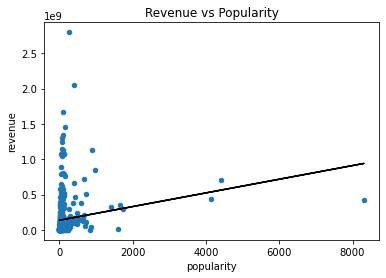

In [4]:
# Minor cleaning, remove movies with any 0s (generally these are unreleased movies)
moviesDF = moviesDF.loc[(moviesDF!=0).all(axis=1)]

# Plot popularity against revenue
ax1 = moviesDF.plot.scatter(x='popularity', y='revenue')
ax1.set_title("Revenue vs Popularity")

# Linear regression on popularity and revenue
popularityCol = moviesDF.loc[:, 'popularity']
revenueCol = moviesDF.loc[:, 'revenue']

m, b = np.polyfit(popularityCol, revenueCol, deg=1)

# Plot regression line
ax1.plot(popularityCol, m*popularityCol + b, color="black")

moviesDF

#The data here is very skewed towards low revenue, low popularity so we'll do a log transformation on the data to get a better visualization. 

-- Log Transformation, note that interpretation of coefficients becomes %'s --

/var/folders/m_/_q2qh5497ddb3x1kq1v1y_y40000gn/T/ipykernel_41792/3997615686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesDF['log popularity'] = popularityColLog
/var/folders/m_/_q2qh5497ddb3x1kq1v1y_y40000gn/T/ipykernel_41792/3997615686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesDF['log revenue'] = revenueColLog


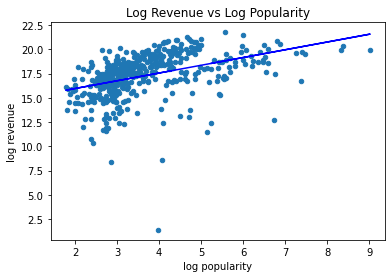

In [9]:
popularityColLog = [np.log(x) for x in popularityCol]
revenueColLog = [np.log(x) for x in revenueCol]

moviesDF['log popularity'] = popularityColLog
moviesDF['log revenue'] = revenueColLog

#Puts popularity and revenue into scatter plot
ax2 = moviesDF.plot.scatter(x='log popularity', y='log revenue')
ax2.set_title("Log Revenue vs Log Popularity")

popularityColLog = moviesDF.loc[:, 'log popularity']
revenueColLog = moviesDF.loc[:, 'log revenue']

#Gets regression line for popularity and revenue and plots it on to scatter plot
m, b = np.polyfit(popularityColLog, revenueColLog, deg=1)
ax2.plot(popularityColLog, m*popularityColLog + b, color="blue")

#From the scatter plot, we see a positive correlation between popularity and revenue. This means as popularity of a movie rises then its revenue will also rises. We had to do a log transformation
#of the data because most of the data was skewed towards low revenue and low popularity. This made the plot difficult to visualize. 

In [ ]:
#Analyzing the relationship (if any) between revenue and budget before and after covid.


-- Pulling covid dataset, include information about source, reason to aggregate, etc etc --

In [6]:
# Reads covid19 worldwide cases csv file
cases_COVID = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_COVID = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

# Aggregating data as we will focus on just aggregate information by date
cases_COVID.drop(columns=['Province/State','Country/Region', 'Lat', 'Long'], inplace=True)
deaths_COVID.drop(columns=['Province/State','Country/Region', 'Lat', 'Long'], inplace=True)

cases_COVID_agg = cases_COVID.sum(axis=0)
deaths_COVID_agg = deaths_COVID.sum(axis=0)

# Calculate daily new cases & deaths
cases_new = cases_COVID_agg.copy()
deaths_new = deaths_COVID_agg.copy()

covid_DF = pd.concat([cases_COVID_agg, cases_new, deaths_COVID_agg, deaths_new], axis=1)
covid_DF.columns = ['Cumulative Cases', 'Daily New Cases', 'Cumulative Deaths', 'Daily New Deaths']
covid_DF.reset_index(inplace=True)

for i in range(1, len(covid_DF)):
    covid_DF.loc[i,'Daily Confirmed Cases'] = covid_DF.loc[i,'Cumulative Cases'] - covid_DF.loc[i-1,'Cumulative Cases']
    covid_DF.loc[i,'Daily Confirmed Deaths'] = covid_DF.loc[i,'Cumulative Deaths'] - covid_DF.loc[i-1,'Cumulative Deaths']

covid_DF.set_index('index', inplace=True)
covid_DF


,Cumulative Cases,Daily New Cases,Cumulative Deaths,Daily New Deaths,Daily Confirmed Cases,Daily Confirmed Deaths
index,,,,,,
1/22/20,557,557,17,17,NaN,NaN
1/23/20,655,655,18,18,98.0,1.0
1/24/20,941,941,26,26,286.0,8.0
1/25/20,1434,1434,42,42,493.0,16.0
1/26/20,2118,2118,56,56,684.0,14.0
...,...,...,...,...,...,...
12/9/21,268558598,268558598,5287902,5287902,724257.0,8700.0
12/10/21,269250556,269250556,5296051,5296051,691958.0,8149.0
12/11/21,269739121,269739121,5301760,5301760,488565.0,5709.0


-- Pull info from COVID DF into movies DF --

In [7]:
moviesDF.loc[:,'cumulative_cases'] = [0] * len(moviesDF)
moviesDF.loc[:,'daily_new_cases'] = [0] * len(moviesDF)
moviesDF.loc[:,'cumulative_deaths'] = [0] * len(moviesDF)
moviesDF.loc[:,'daily_new_deaths'] = [0] * len(moviesDF)

for i, row in moviesDF.iterrows():
    curr_date = row['release_date'].split('-')
    curr_date[0] = curr_date[0][len(curr_date[0])//2:]
    date = str(int(curr_date[1])) + '/' + curr_date[2] + '/' + curr_date[0]
    try:
        covid_row = covid_DF.loc[date]
        moviesDF.loc[i, 'cumulative_cases'] = covid_row.loc['Cumulative Cases']
        moviesDF.loc[i, 'daily_new_cases'] = covid_row.loc['Daily Confirmed Cases']
        moviesDF.loc[i, 'cumulative_deaths'] = covid_row.loc['Cumulative Deaths']
        moviesDF.loc[i, 'daily_new_deaths'] = covid_row.loc['Daily Confirmed Deaths']
    except KeyError:
        pass

moviesDF


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,title,release_date,popularity,vote_average,vote_count,revenue,budget,log popularity,log revenue,cumulative_cases,daily_new_cases,cumulative_deaths,daily_new_deaths
0,Bad Boys for Life,2020-01-17,73.253,7.2,6645,426505244,90000000,4.293919,19.871135,0,0,0,0
1,Super Troopers 2,2018-04-20,12.451,5.8,322,18850674,13500000,2.521801,16.752059,0,0,0,0
2,Pet Sematary,2019-04-05,24.863,5.7,2559,112399944,21000000,3.213381,18.537574,0,0,0,0
3,How to Train Your Dragon: The Hidden World,2019-02-22,61.609,7.8,4810,517526875,129000000,4.120808,20.064572,0,0,0,0
4,Star Wars: The Rise of Skywalker,2019-12-20,62.079,6.5,7223,1074144248,250000000,4.128408,20.794790,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,PAW Patrol: The Movie,2021-08-20,577.741,7.7,678,135000000,26000000,6.359126,18.720785,211363932,790138,4415353,10464
1860,After We Fell,2021-09-30,1612.828,7.3,882,19000000,14000000,7.385744,16.759950,234209471,484766,4784875,8837
1864,Cry Macho,2021-09-17,64.973,6.5,289,11780000,33000000,4.173972,16.281914,228085684,593543,4679905,8688
1899,Zack Snyder's Justice League,2021-03-18,391.146,8.4,6850,657000000,70000000,5.969081,20.303195,122176750,543903,2775706,10725


-- Advanced Regression Models --

popularity v cases

popularity v death rates

revenue v cases


In [8]:
pop_by_case = smf.ols('popularity~cumulative_cases', data=moviesDF).fit()
print(pop_by_case.summary())


                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     21.84
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           3.92e-06
Time:                        16:48:28   Log-Likelihood:                -3431.3
No. Observations:                 449   AIC:                             6867.
Df Residuals:                     447   BIC:                             6875.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           84.8673     25.585  